# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch

In [3]:
from utils import MnistData, Clipper
from models import ModelManager, ModelType
from adversarials import ClassificationAdversarials

In [4]:
import numpy as np
from matplotlib import pyplot as plt

# Settings

In [5]:
linfty_norm_radius = 50 / 255
lone_norm_radius = 28 * 28 * 50 / 255
ltwo_norm_radius = 28 * 50 / 255

In [6]:
model = ModelManager.get_trained(ModelType.MnistCnnBRobust)

In [7]:
batch_size = 100

In [8]:
data = MnistData(True)

In [34]:
c_lambda = 0.1

# CW functions

In [10]:
def mnist_batch_linfty_norm(input:torch.Tensor) -> torch.Tensor:
    return torch.max(torch.max(torch.max(torch.abs(input), dim=3)[0], dim=2)[0], dim=1)[0]

def mnist_batch_lone_norm(input:torch.Tensor) -> torch.Tensor:
    return (torch.abs(input)).sum(3).sum(2).sum(1)

def mnist_batch_ltwo_norm(input:torch.Tensor) -> torch.Tensor:
    return ((input ** 2).sum(3).sum(2).sum(1)) ** (1 / 2)

In [11]:
def cw_batch_clip_always(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, norm_radius, c_lambda: float, batch_norm) -> torch.Tensor:
    adversarial_examples = torch.zeros(benign_examples.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    step_size = 1e-2
    for _ in range(100):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        benign_examples.requires_grad = True
        if benign_examples.grad is not None:
            benign_examples.grad.zero_()
        loss = batch_norm(adversarial_examples - benign_examples).sum() - c_lambda * loss_fn(model(adversarial_examples), labels)
        loss.backward()
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)).detach()
        adversarial_examples = Clipper.clip_batch(benign_examples, adversarial_examples, batch_norm, norm_radius)
    # return Clipper.clip_batch(benign_examples, adversarial_examples, batch_norm, norm_radius)
    return adversarial_examples

def cw_batch_clip_once(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, norm_radius, c_lambda: float, batch_norm) -> torch.Tensor:
    adversarial_examples = torch.zeros(benign_examples.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    step_size = 1e-2
    for _ in range(100):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        benign_examples.requires_grad = True
        if benign_examples.grad is not None:
            benign_examples.grad.zero_()
        loss = batch_norm(adversarial_examples - benign_examples).sum() - c_lambda * loss_fn(model(adversarial_examples), labels)
        loss.backward()
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)).detach()
        # adversarial_examples = Clipper.clip_batch(benign_examples, adversarial_examples, batch_norm, norm_radius)
    return Clipper.clip_batch(benign_examples, adversarial_examples, batch_norm, norm_radius)
    # return adversarial_examples

# Generation

In [12]:
benign_examples, labels = data.choose_first_well_classified(batch_size, model)

In [35]:
cw_linfty_examples_clip_always = cw_batch_clip_always(model, benign_examples, labels, linfty_norm_radius, c_lambda, mnist_batch_linfty_norm)
cw_lone_examples_clip_always = cw_batch_clip_always(model, benign_examples, labels, lone_norm_radius, c_lambda, mnist_batch_lone_norm)
cw_ltwo_examples_clip_always = cw_batch_clip_always(model, benign_examples, labels, ltwo_norm_radius, c_lambda, mnist_batch_ltwo_norm)

cw_linfty_examples_clip_once = cw_batch_clip_once(model, benign_examples, labels, linfty_norm_radius, c_lambda, mnist_batch_linfty_norm)
cw_lone_examples_clip_once = cw_batch_clip_once(model, benign_examples, labels, lone_norm_radius, c_lambda, mnist_batch_lone_norm)
cw_ltwo_examples_clip_once = cw_batch_clip_once(model, benign_examples, labels, ltwo_norm_radius, c_lambda, mnist_batch_ltwo_norm)

In [36]:

cw_linfty_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_linfty_examples_clip_always)
print(f'cw_linfty_always: {len(cw_linfty_adversarials)}')

cw_lone_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_lone_examples_clip_always)
print(f'cw_lone_always: {len(cw_lone_adversarials)}')

cw_ltwo_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_ltwo_examples_clip_always)
print(f'cw_ltwo_always: {len(cw_ltwo_adversarials)}')

cw_linfty_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_linfty_examples_clip_once)
print(f'cw_linfty_once: {len(cw_linfty_adversarials)}')

cw_lone_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_lone_examples_clip_once)
print(f'cw_lone_once: {len(cw_lone_adversarials)}')

cw_ltwo_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_ltwo_examples_clip_once)
print(f'cw_ltwo_once: {len(cw_ltwo_adversarials)}')

cw_linfty_always: 0
cw_lone_always: 0
cw_ltwo_always: 0
cw_linfty_once: 0
cw_lone_once: 0
cw_ltwo_once: 0


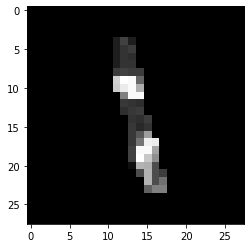

In [25]:
example = np.array(cw_lone_examples_clip_once[99].detach()).reshape(28, 28)
plt.imshow(example, cmap='gray', vmin=0, vmax=1)

In [24]:
cw_lone_adversarials

[{'Label': tensor(5),
  'Prediction': 1,
  'Confidence': 0.9469121694564819,
  'Index': 0,
  'OriginalPrediction': 5,
  'OriginalConfidence': 0.9997236132621765},
 {'Label': tensor(0),
  'Prediction': 1,
  'Confidence': 0.977895200252533,
  'Index': 1,
  'OriginalPrediction': 0,
  'OriginalConfidence': 1.0},
 {'Label': tensor(4),
  'Prediction': 1,
  'Confidence': 0.9602501392364502,
  'Index': 2,
  'OriginalPrediction': 4,
  'OriginalConfidence': 0.9999998807907104},
 {'Label': tensor(1),
  'Prediction': 7,
  'Confidence': 0.9847805500030518,
  'Index': 3,
  'OriginalPrediction': 1,
  'OriginalConfidence': 0.9999986886978149},
 {'Label': tensor(9),
  'Prediction': 1,
  'Confidence': 0.9573586583137512,
  'Index': 4,
  'OriginalPrediction': 9,
  'OriginalConfidence': 0.9998965263366699},
 {'Label': tensor(2),
  'Prediction': 1,
  'Confidence': 0.939198911190033,
  'Index': 5,
  'OriginalPrediction': 2,
  'OriginalConfidence': 1.0},
 {'Label': tensor(1),
  'Prediction': 7,
  'Confidence

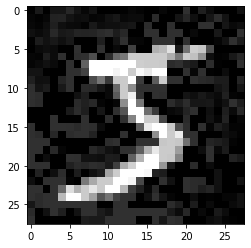

In [27]:
example = np.array(cw_linfty_examples_clip_always[0].detach()).reshape(28, 28)
plt.imshow(example, cmap='gray', vmin=0, vmax=1)